<a href="https://colab.research.google.com/github/MerveSevim44/toot_dency_detection_deep_learning/blob/main/Di%C5%9F_%C3%87%C3%BCr%C3%BC%C4%9F%C3%BC_Tespiti_G%C3%B6r%C3%BCnt%C3%BC_%C4%B0%C5%9Fleme_Projesi_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [ ]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import cv2
import os


input_path = "/content/drive/MyDrive/Colab Notebooks/Panoramic Dental X-rays With Segmented Mandibles"

# Çıkış klasörlerini oluştur
os.makedirs(f"{input_path}/images_cut", exist_ok=True)
os.makedirs(f"{input_path}/labels_cut", exist_ok=True)

# 'images' klasöründeki tüm .png dosyalarını al
image_files = sorted([f for f in os.listdir(f"{input_path}/Images") if f.endswith(".png")])

for file_name in image_files:
    base_name = os.path.splitext(file_name)[0]

    img = cv2.imread(f"{input_path}/Images/{base_name}.png", 0)
    roi = cv2.imread(f"{input_path}/Segmentation1/{base_name}.png", 0)
    label = cv2.imread(f"{input_path}/Segmentation2/{base_name}.png", 0)

    if img is None or roi is None or label is None:
        print(f"{base_name}.png için dosya eksik, atlandı.")
        continue

    # Resize roi and label to match img size
    roi_resized = cv2.resize(roi, (img.shape[1], img.shape[0]))
    label_resized = cv2.resize(label, (img.shape[1], img.shape[0]))

    img_cut = cv2.bitwise_and(img, roi_resized)
    label_cut = cv2.bitwise_and(label_resized, roi_resized) # Apply the roi mask to the label image as well.

    cv2.imwrite(f"{input_path}/images_cut/{base_name}.png", img_cut)
    cv2.imwrite(f"{input_path}/labels_cut/{base_name}.png", label_cut)

print("Tüm görüntüler başarıyla işlendi ✅")

Tüm görüntüler başarıyla işlendi ✅


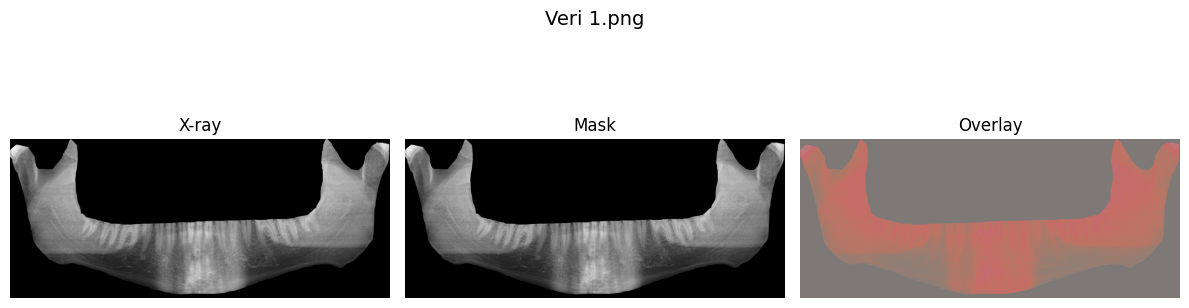

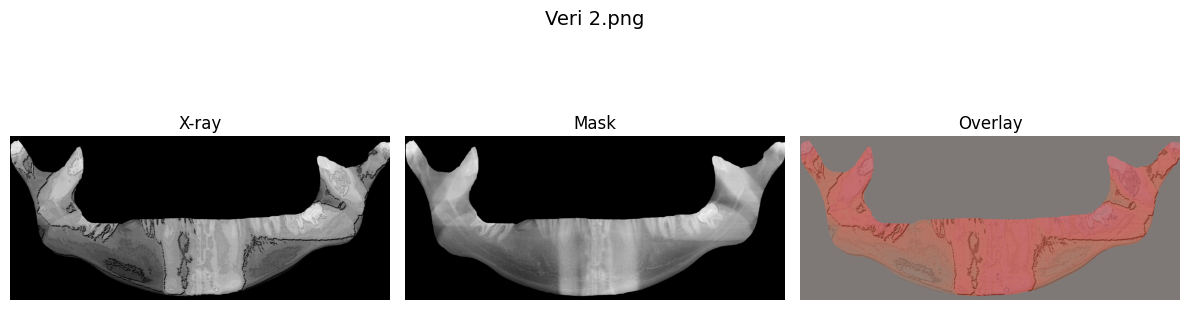

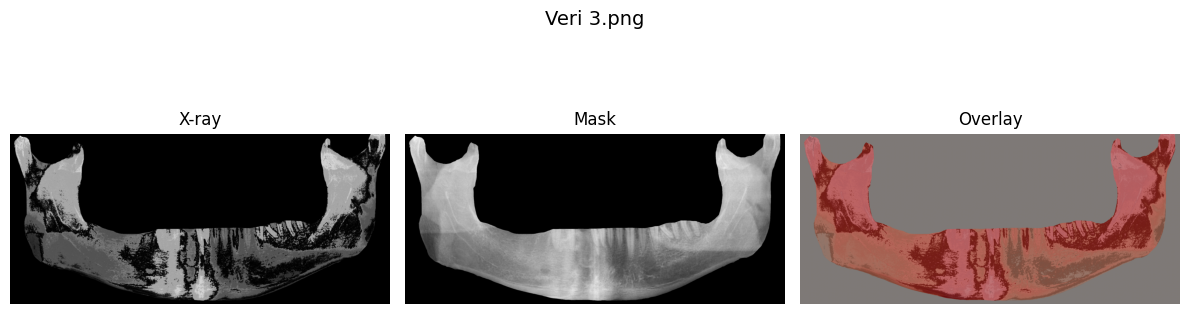

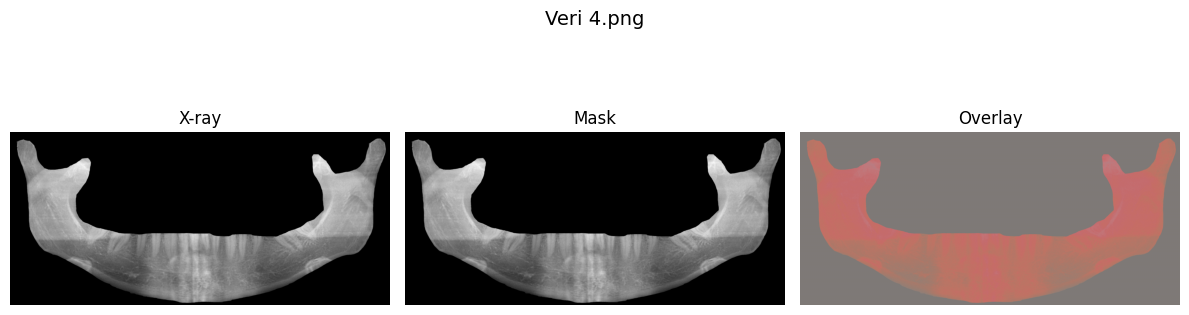

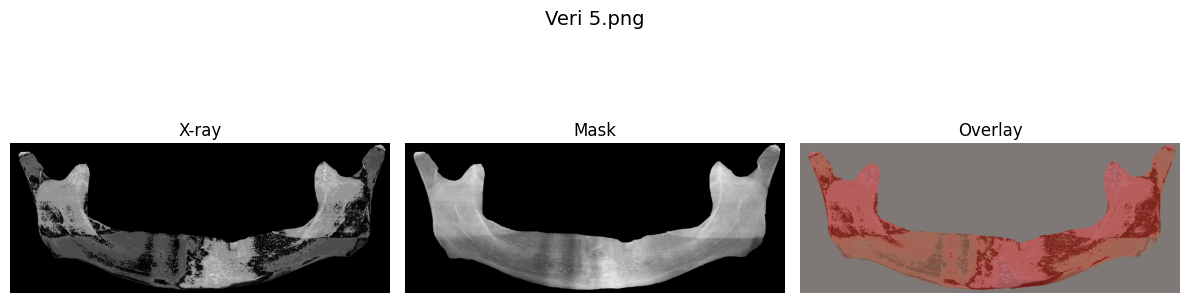

In [ ]:
import matplotlib.pyplot as plt
import cv2

for i in range(1, 6):
    img = cv2.imread(f"{input_path}/images_cut/{i}.png", 0)
    label = cv2.imread(f"{input_path}/labels_cut/{i}.png", 0)

    if img is None or label is None:
        print(f"{i}.png için veri bulunamadı, atlandı.")
        continue

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Veri {i}.png", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("X-ray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.imshow(label, cmap='Reds', alpha=0.5)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
IMG_SIZE = 256
X, Y = [], []

# Görüntüler
for path in sorted(glob(f"{input_path}/images_cut/*.png")):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img)

# Maskeler
for path in sorted(glob(f"{input_path}/labels_cut/*.png")):
    mask = cv2.imread(path, 0)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)  # ikili hale getir
    Y.append(mask)

X = np.array(X) / 255.0
Y = np.array(Y)

# Kanal ekle
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)

# Eğitim/Doğrulama ayır
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(gamma=2., alpha=0.25):
    def focal(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal

def final_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * focal_loss()(y_true, y_pred)

In [ ]:
from tensorflow.keras import layers, models

def get_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.3)(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.3)(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(b)
    b = layers.BatchNormalization()(b)
    b = layers.Dropout(0.3)(b)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model


In [ ]:

"""
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras import layers, models
import tensorflow as tf

def build_model(hp):
    inputs = tf.keras.Input(shape=(256, 256, 1))

    # Hiperparametre: filtre sayısı
    f1 = hp.Choice("filters_1", values=[16, 32])
    f2 = hp.Choice("filters_2", values=[32, 64])

    # Encoder
    c1 = layers.Conv2D(f1, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(f1, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(f2, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(f2, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(f2 * 2, 3, activation='relu', padding='same')(p2)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(f2 * 2, 3, activation='relu', padding='same')(b)
    b = layers.BatchNormalization()(b)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(f2, 3, activation='relu', padding='same')(u1)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(f2, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(f1, 3, activation='relu', padding='same')(u2)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(f1, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)

    # Hiperparametre: optimizer seçimi
    optimizer_choice = hp.Choice("optimizer", ['adam', 'rmsprop'])

    model.compile(
        optimizer=optimizer_choice,
        loss=combined_loss,
        metrics=[dice_coef]
    )

    return model
    """

In [ ]:
"""
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,            # denenecek kombinasyon sayısı
    executions_per_trial=1,   #her kombinasyon sadece 1 kere çalıştırılacak
    directory='bayes_opt_dir', #bayes_opt_dir/dental_unet/ klasöründe saklanacak böylece izlenebilir ve tekar devam ettirilebilir
                               #olabilecek
    project_name='dental_unet'
)

# Erken durdurma (opsiyonel ama önerilir)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, Y_train,
             epochs=10,
             validation_data=(X_val, Y_val),
             callbacks=[earlystop])


# Aramayı başlat
best_model = tuner.get_best_models(num_models=1)[0]

"""



In [ ]:
"""
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters()[0]

print("En iyi hiperparametreler:")
print(best_hyperparams.values)
"""

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Batch size
BATCH_SIZE = 4

# ⏩ 1. Data Augmentation yapılandır
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ⏩ 2. generator fonksiyonu tanımla
def generator(X, Y, batch_size):
    gen = datagen.flow(X, Y, batch_size=batch_size)
    for x_batch, y_batch in gen:
        yield x_batch, y_batch

# ⏩ 3. train_ds augmentation'lı tanımlanıyor
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(X_train, Y_train, BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

# ⏩ 4. val_ds (augmentation uygulanmaz)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# ⏩ 5. Model oluştur, derle
model = get_unet()
model.compile(
    optimizer='adam',
    loss=final_loss,
    metrics=[dice_coef]
)
model.summary()

# ⏩ 6. Early stopping tanımı
earlystop = EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)

# ⏩ 7. Eğitim başlat
try:
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        steps_per_epoch=1000,
                        callbacks=[earlystop])
except tf.errors.ResourceExhaustedError:
    print("⚠️ GPU belleği tükendi! Batch size'ı daha da düşür (örneğin 2).")

# ⏩ 8. Kaç epoch sürdüğünü yazdır
print(f"Eğitim tamamlandı. Toplam epoch: {len(history.history['loss'])}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ dropout_4[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_16[0][0] 

 Total params: 119,265 (465.88 KB)

 Trainable params: 118,625 (463.38 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - dice_coef: 0.5927 - loss: 0.2147 - val_dice_coef: 0.4266 - val_loss: 0.3419
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - dice_coef: 0.6347 - loss: 0.1947 - val_dice_coef: 0.6862 - val_loss: 0.1683
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - dice_coef: 0.6454 - loss: 0.1888 - val_dice_coef: 0.4812 - val_loss: 0.3024
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - dice_coef: 0.6480 - loss: 0.1874 - val_dice_coef: 0.6015 - val_loss: 0.2199
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - dice_coef: 0.6510 - loss: 0.1858 - val_dice_coef: 0.7328 - val_loss: 0.1400
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - dice_coef: 0.6512 - loss: 0.1856 - val_dice_coef: 0.7193 - val_loss: 0.1508
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - dice_coef: 0.6556 - loss: 0.1833 - val_dice_coef: 0.7251 - val_loss: 0.1509
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - dice

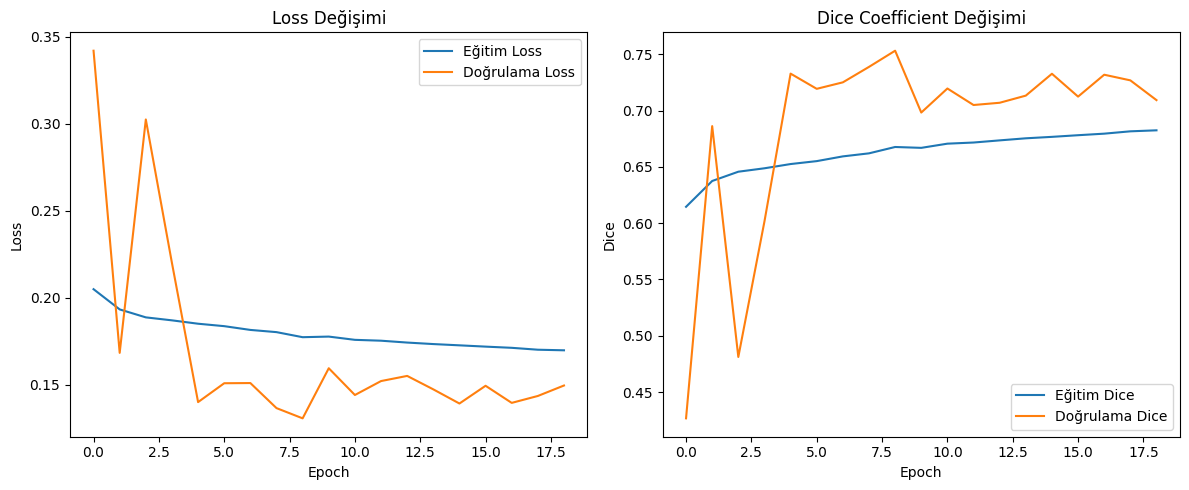

In [ ]:
import matplotlib.pyplot as plt

# Overfitting kontrolü - Loss ve Dice grafikleri
plt.figure(figsize=(12, 5))

# Kayıp (Loss) grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Eğitim Loss")
plt.plot(history.history["val_loss"], label="Doğrulama Loss")
plt.title("Loss Değişimi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Dice Coefficient (veya başka metric) grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history["dice_coef"], label="Eğitim Dice")
plt.plot(history.history["val_dice_coef"], label="Doğrulama Dice")
plt.title("Dice Coefficient Değişimi")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


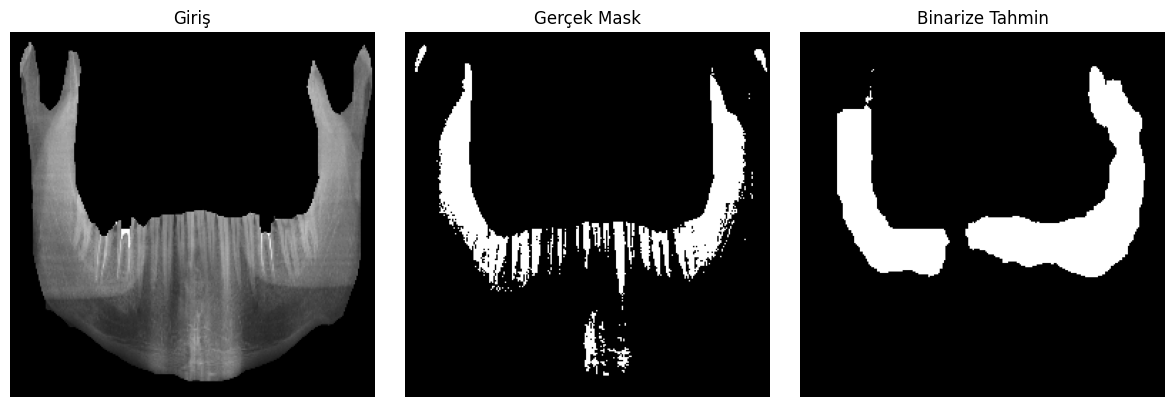

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


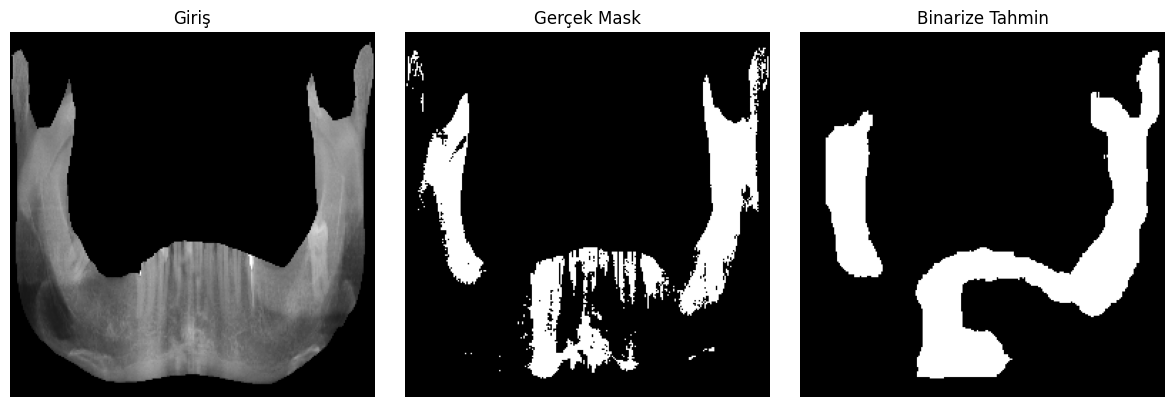

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


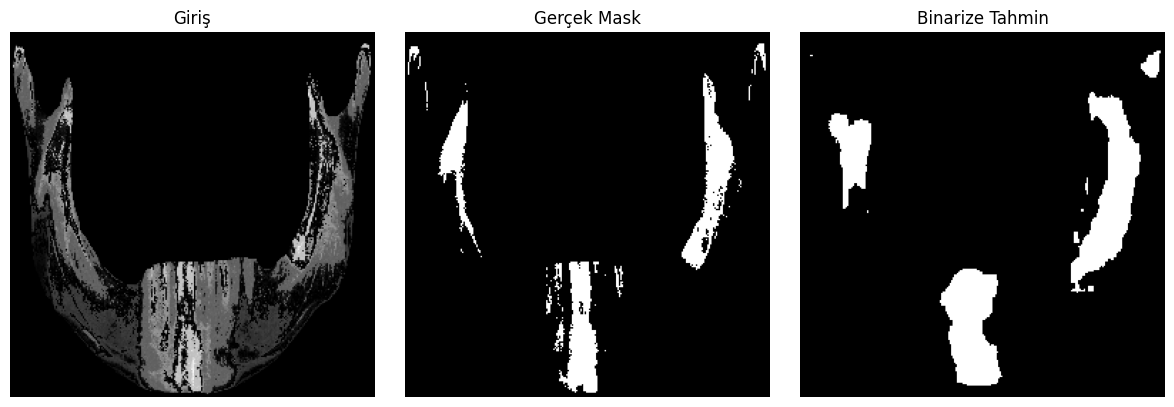

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


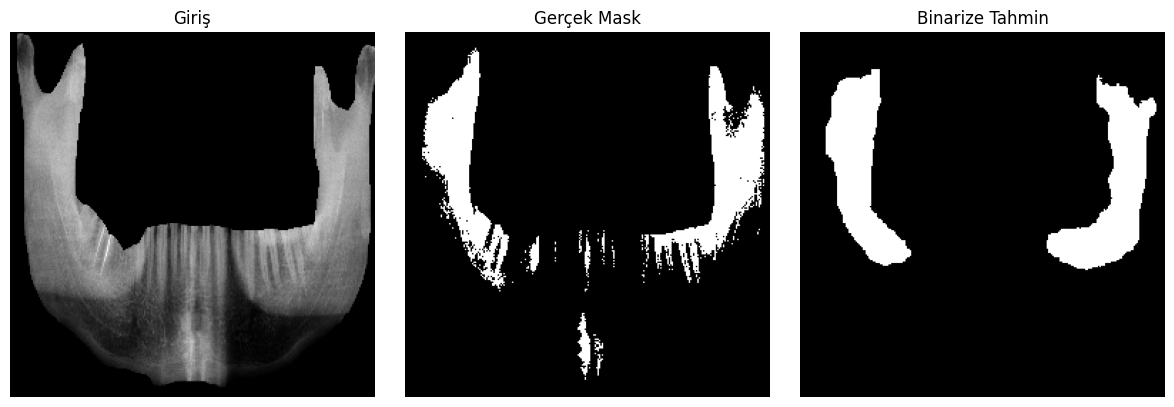

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


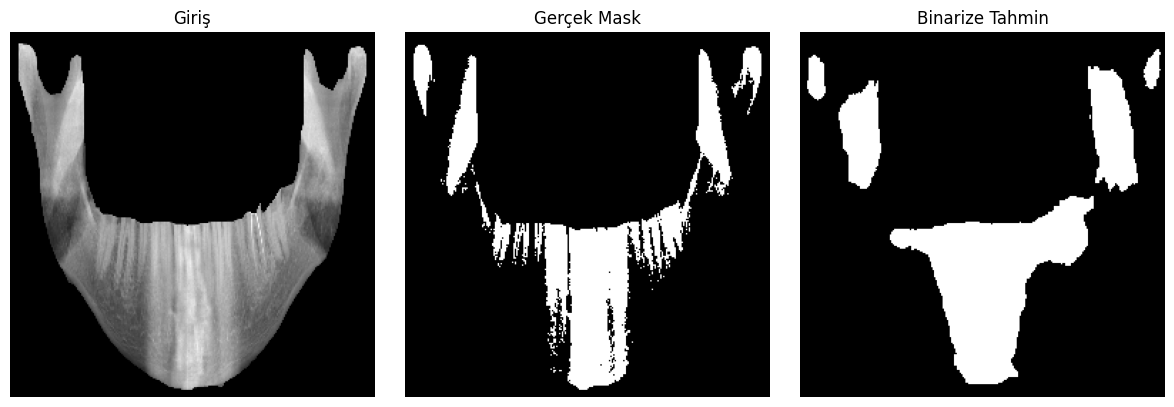

In [ ]:
# 1. Rastgele birkaç örnek al (görselleştirme için)
import matplotlib.pyplot as plt

for i in range(5):  # Kaç örnek göstermek istiyorsan
    idx = np.random.randint(0, len(X_val))
    x = X_val[idx]
    y_true = Y_val[idx]

    # 2. Tahmin yap
    pred = model.predict(np.expand_dims(x, axis=0))[0]

    # 3. Binarize et (0.5 threshold ile)
    pred_binary = (pred > 0.5).astype(np.uint8)

    # 4. Görselleştir
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x.squeeze(), cmap='gray')
    plt.title("Giriş")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(y_true.squeeze(), cmap='gray')
    plt.title("Gerçek Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Binarize Tahmin")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
model.save("dental_caries_unet_best2.h5")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("dental_caries_unet_best2.h5", custom_objects={"dice_coef": dice_coef, "combined_loss": combined_loss})


In [ ]:
model.compile(optimizer='adam', loss=final_loss, metrics=[dice_coef])
